# IML - P2

![15560369383553_2c2.jpg](input/15560369383553_2c2.jpg)

1. Select Data

2. Clean up Data

3. Transform Data


# Exploratory Data Analysis

## What's provided ?

### Target

Show representations of the dataset through univariate and multivariate analysis

main interesting feature are:
* nutriscore_score
* nutriscore_grade

### Size / Nb lines & columns

Data set contains 186 columns and approx 2Mio lignes

### Types of features / variables

it contains a mix of types : dates, strings, numbers

Interesting ones:

#### Qualitative
* countries_tags
* allergens
* traces
* additives
* pnns_groups_1 [explanation (fr)](https://solidarites-sante.gouv.fr/IMG/pdf/pnns4_2019-2023.pdf)
* pnns_groups_2
* nova_group [explanation (fr)](https://www.thierrysouccar.com/nutrition/info/nova-une-classification-des-aliments-basee-sur-la-science-3936)
* brand_owner ?
* main_category

#### Quantitative
* serving_size
* serving_quantity
* no_nutriments
* additives_n
* ingredients_from_palm_oil_n
* ingredients_that_may_be_from_palm_oil_n
* nutriscore_score
* nutriscore_grade
* ecoscore_score_fr
* ecoscore_grade_fr

Detailed variables :

* abcd_100g

### Missing values identification

What are the features which have lots of NaN / empty values ?


## What's in it ?

* Target visualisation (hist, boxplot)

* Features comprehension

* Features - target relations

* Outliers recognition

In [3]:
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno


os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
import modin.pandas as pd
import ray
ray.init(ignore_reinit_error=True)

{'node_ip_address': '192.168.0.10',
 'raylet_ip_address': '192.168.0.10',
 'redis_address': '192.168.0.10:6379',
 'object_store_address': '/tmp/ray/session_2021-11-02_20-23-01_500824_15821/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-02_20-23-01_500824_15821/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-11-02_20-23-01_500824_15821',
 'metrics_export_port': 60246,
 'node_id': '87270bf7b334d60bc1eb3a37b6472eef1ac26529b805426714a27c25'}

In [4]:
df = pd.read_csv('input/open-food-facts/en.openfoodfacts.org.products.csv', sep='\t', parse_dates=['created_datetime','last_modified_datetime'])

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


In [5]:
df_bck = df.copy()

In [6]:
df.shape

(1988476, 186)

In [7]:
# pd.set_option('display.max_columns', None)
df.head()


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16 14:53:28+00:00,1623855209,2021-06-16 14:53:29+00:00,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01 08:11:51+00:00,1630484064,2021-09-01 08:14:24+00:00,L.casei,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15 10:38:00+00:00,1561463718,2019-06-25 11:55:18+00:00,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13 21:06:14+00:00,1539464817,2018-10-13 21:06:57+00:00,Cacao,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19 15:02:16+00:00,1624390765,2021-06-22 19:39:25+00:00,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.describe()

,created_t,last_modified_t,cities,allergens_en,serving_quantity,no_nutriments,additives_n,additives,ingredients_from_palm_oil_n,ingredients_from_palm_oil,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,1.988476e+06,1.988476e+06,0.0,0.0,4.975140e+05,0.0,722441.000000,0.0,722441.000000,0.0,...,11867.000000,719224.000000,8.000000,4.000000,1.0,63.000000,1712.000000,38.000000,69.000000,39.000000
mean,1.560070e+09,1.595301e+09,NaN,NaN,2.233335e+16,NaN,2.029187,NaN,0.020294,NaN,...,615.324945,9.103861,13.875000,34.175000,9100.0,3.238417,0.068921,3.278158,2.201766,0.025676
std,5.296541e+07,3.116836e+07,NaN,NaN,1.575269e+19,NaN,2.899762,NaN,0.142943,NaN,...,6082.140585,8.842205,8.576338,15.620153,NaN,18.705382,1.826776,1.562956,12.669790,0.090002
min,1.328021e+09,1.333873e+09,NaN,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000,NaN,...,0.049000,-15.000000,1.000000,14.000000,9100.0,0.000000,0.000000,0.400000,0.001350,0.000800
25%,1.524120e+09,1.582759e+09,NaN,NaN,2.800000e+01,NaN,0.000000,NaN,0.000000,NaN,...,107.800000,1.000000,8.250000,26.000000,9100.0,0.056500,0.000008,2.450000,0.010000,0.007050
50%,1.571243e+09,1.599393e+09,NaN,NaN,5.300000e+01,NaN,1.000000,NaN,0.000000,NaN,...,328.500000,10.000000,15.500000,37.000000,9100.0,0.073600,0.000023,3.600000,0.025000,0.011000
75%,1.603225e+09,1.619531e+09,NaN,NaN,1.133981e+02,NaN,3.000000,NaN,0.000000,NaN,...,614.200000,16.000000,22.000000,45.175000,9100.0,0.125000,0.000096,4.000000,0.047000,0.015000
max,1.634172e+09,1.634172e+09,NaN,NaN,1.111111e+22,NaN,49.000000,NaN,3.000000,NaN,...,656298.600000,40.000000,22.000000,48.700000,9100.0,136.000000,54.000000,7.300000,75.000000,0.572000


In [12]:
df.columns.size

186

In [13]:
for col in df.columns:
    print(col)

code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
abbreviated_product_name
generic_name
quantity
packaging
packaging_tags
packaging_text
brands
brands_tags
categories
categories_tags
categories_en
origins
origins_tags
origins_en
manufacturing_places
manufacturing_places_tags
labels
labels_tags
labels_en
emb_codes
emb_codes_tags
first_packaging_code_geo
cities
cities_tags
purchase_places
stores
countries
countries_tags
countries_en
ingredients_text
allergens
allergens_en
traces
traces_tags
traces_en
serving_size
serving_quantity
no_nutriments
additives_n
additives
additives_tags
additives_en
ingredients_from_palm_oil_n
ingredients_from_palm_oil
ingredients_from_palm_oil_tags
ingredients_that_may_be_from_palm_oil_n
ingredients_that_may_be_from_palm_oil
ingredients_that_may_be_from_palm_oil_tags
nutriscore_score
nutriscore_grade
nova_group
pnns_groups_1
pnns_groups_2
states
states_tags
states_en
brand_owner
ecoscore_score_fr
ecoscore_grade_fr


## Features Types

In [14]:
df.dtypes[['created_t','created_datetime','last_modified_t', 'last_modified_datetime']]

created_t                               int64
created_datetime          datetime64[ns, UTC]
last_modified_t                         int64
last_modified_datetime    datetime64[ns, UTC]
dtype: object

In [15]:
df['created_t']

0          1623855208
1          1630483911
2          1529059080
3          1539464774
4          1574175736
              ...    
1988471    1572513866
1988472    1608105503
1988473    1581171613
1988474    1613129728
1988475    1587222660
Name: created_t, Length: 1988476, dtype: int64

<AxesSubplot:ylabel='None'>

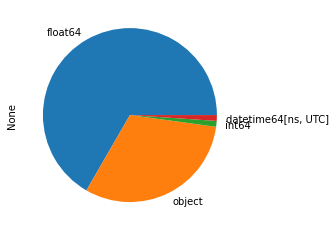

In [16]:
# Features types repartition 
df.dtypes.value_counts().plot.pie()

## Cleaning unecessary data


### Remove empty columns 

let's compute the ratio: $ \frac{\text{empty values}}{\text{nb rows}} $

In [17]:
pd.set_option('display.max_rows', None)

(apply_func pid=16228) 


To request implementation, send an email to feature_requests@modin.org.


<AxesSubplot:ylabel='Frequency'>

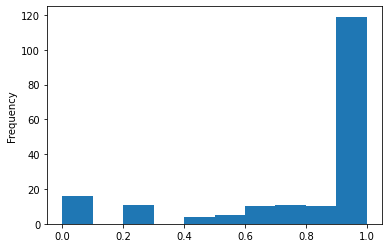

In [18]:
df.isna().mean().sort_values().plot(kind="hist")

we can see that about 120 columns have more than 80% of empty cells, so the dataset despite being large, is almost empty !

<AxesSubplot:>

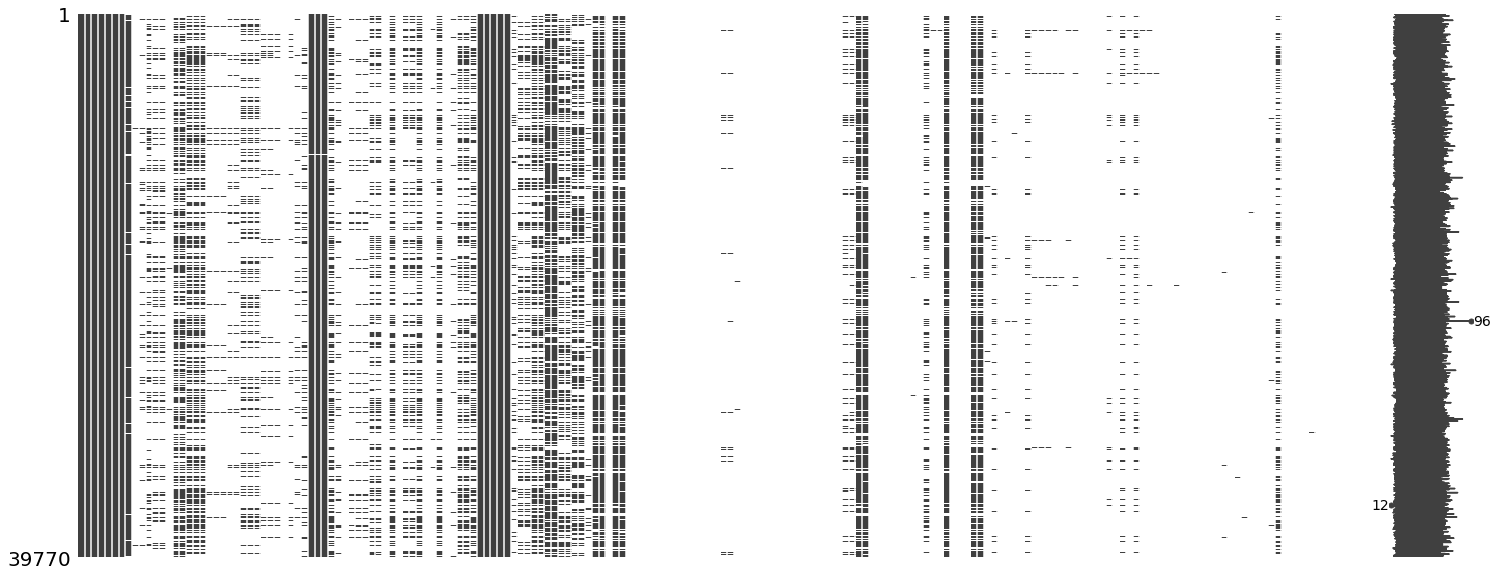

In [19]:
msno.matrix(df.sample(round(df.shape[0]*0.02)))

We can see there are some plateau of columns missing data, let's consider we want to remove at least those that have more than 80% of missing value.

In [20]:
threshold = 0.7
df = df[df.columns[df.isna().mean() < threshold]]

<AxesSubplot:>

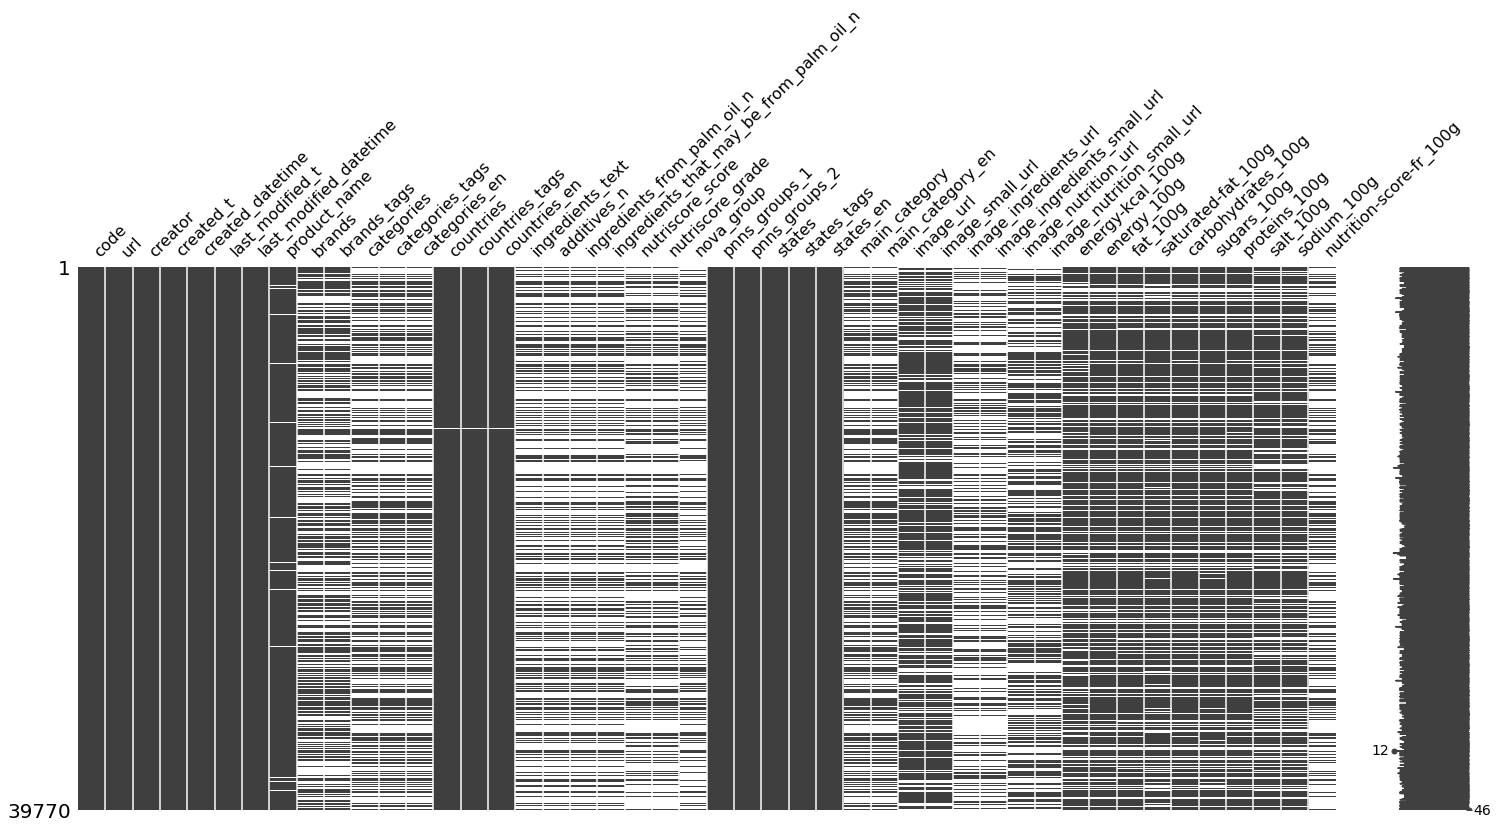

In [21]:
msno.matrix(df.sample(round(df.shape[0]*0.02)))

In [22]:
df.columns.size

46

<AxesSubplot:>

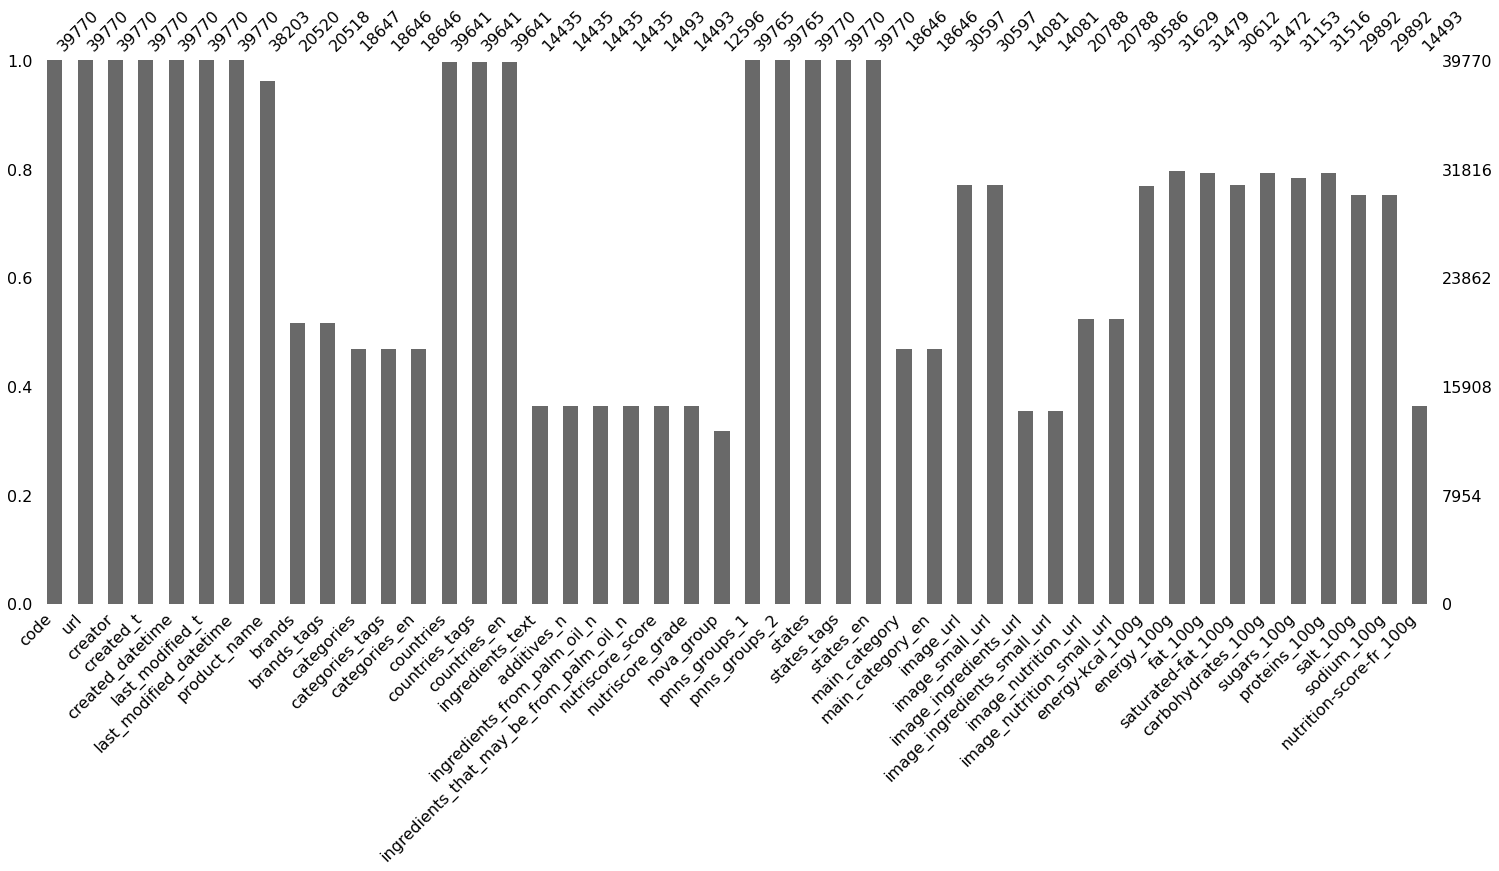

In [23]:
msno.bar(df.sample(round(df.shape[0]*0.02)))

### Remove not interesting columns

List remaining columns, remove the obviouses manually

In [24]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_en',
       'countries', 'countries_tags', 'countries_en', 'ingredients_text',
       'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'states', 'states_tags', 'states_en', 'main_category',
       'main_category_en', 'image_url', 'image_small_url',
       'image_ingredients_url', 'image_ingredients_small_url',
       'image_nutrition_url', 'image_nutrition_small_url', 'energy-kcal_100g',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

#### Remove 'url' features

In [25]:
df.filter(regex='url').columns.values

array(['url', 'image_url', 'image_small_url', 'image_ingredients_url',
       'image_ingredients_small_url', 'image_nutrition_url',
       'image_nutrition_small_url'], dtype=object)

In [26]:
df = df.drop(df.filter(regex='url').columns.values, axis=1)

In [27]:
df.columns.size

39

#### Remove timestamp (duplicate of *_datetime columns) + misc

In [28]:
df.drop({
    'code',
    'creator', 
    'created_t', 
    'last_modified_t', 
        }, axis=1, inplace=True)

<AxesSubplot:ylabel='None'>

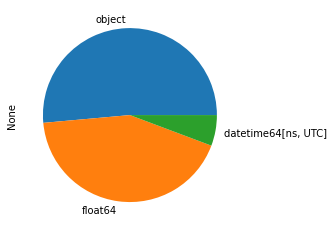

In [29]:
# repartition of value types in the dataset
df.dtypes.value_counts().plot.pie()

In [30]:
df.columns.size

35

We have now a cleaned data set, without 'empty' columns, and columns we don't care.

Let's dig further to carefully look into the features, regarding their types, if we can remove some more

# ANALYSIS

## Qualitative Values

With a pre-filtered dataset. 

Let's look at the qualitative values, which ones are of interest


### dispertion of values

Let's show object features with their unique values : we are looking for features that contains just a few values, otherwise this is not interesting

In [31]:
df.columns[df.dtypes == 'object']

Index(['product_name', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_en', 'countries', 'countries_tags',
       'countries_en', 'ingredients_text', 'nutriscore_grade', 'pnns_groups_1',
       'pnns_groups_2', 'states', 'states_tags', 'states_en', 'main_category',
       'main_category_en'],
      dtype='object')

In [32]:
df['categories'].mode()

0    Snacks
Name: categories, dtype: object

In [33]:
df['countries_tags'].mode()

0    en:france
Name: countries_tags, dtype: object

In [34]:
for col in df.select_dtypes('object'):
    print(f'{col} {(df[col].unique().size / df[col].size):.0%}')

product_name 62%
brands 9%
brands_tags 7%
categories 6%
categories_tags 4%
categories_en 4%
countries 1%
countries_tags 0%
countries_en 0%
ingredients_text 31%
nutriscore_grade 0%
pnns_groups_1 0%
pnns_groups_2 0%
states 0%
states_tags 0%
states_en 0%
main_category 2%
main_category_en 2%


We remove the columns with a higher percentage of not unique values, because they will result in a too big variance

So, we should only keep:

countries_en, additives_tags, nutriscore_grade, pnns_groups_1,pnns_groups_2,ecoscore_grade_fr,

## Quantitative Values

### Empirical Variance (Variance Empirique)

$ \upsilon = \frac{1}{n} \sum_{i=1}^n(x_i - \bar{x})²$

### Standard Deviation (Ecart-Type Empirique)

$ s = \sqrt{\upsilon} $ 


In [35]:
df.columns[df.dtypes == 'int']

Index([], dtype='object')

In [36]:
df.columns[df.dtypes == 'float']

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nova_group', 'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

{'whiskers': [<matplotlib.lines.Line2D at 0x1cea7bdf0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ceab9490>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cea7b8b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1ceab9bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ceab9f70>],
 'means': []}

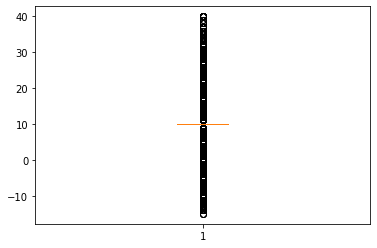

In [37]:
plt.boxplot(df['nutriscore_score'].fillna(df['nutriscore_score'].median()))

<AxesSubplot:>

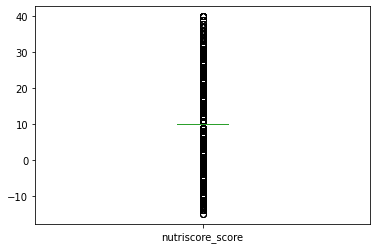

In [38]:
df['nutriscore_score'].fillna(df['nutriscore_score'].median()).plot(kind='box')

In [39]:
for col in df.select_dtypes('float'):
    print(col)
    

additives_n
ingredients_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_n
nutriscore_score
nova_group
energy-kcal_100g
energy_100g
fat_100g
saturated-fat_100g
carbohydrates_100g
sugars_100g
proteins_100g
salt_100g
sodium_100g
nutrition-score-fr_100g


## Resulting Dataset

We can see that some columns still have lots of empty values, but also that several rows have almost (or all) the features provided,
which is good for further analysis

<AxesSubplot:>

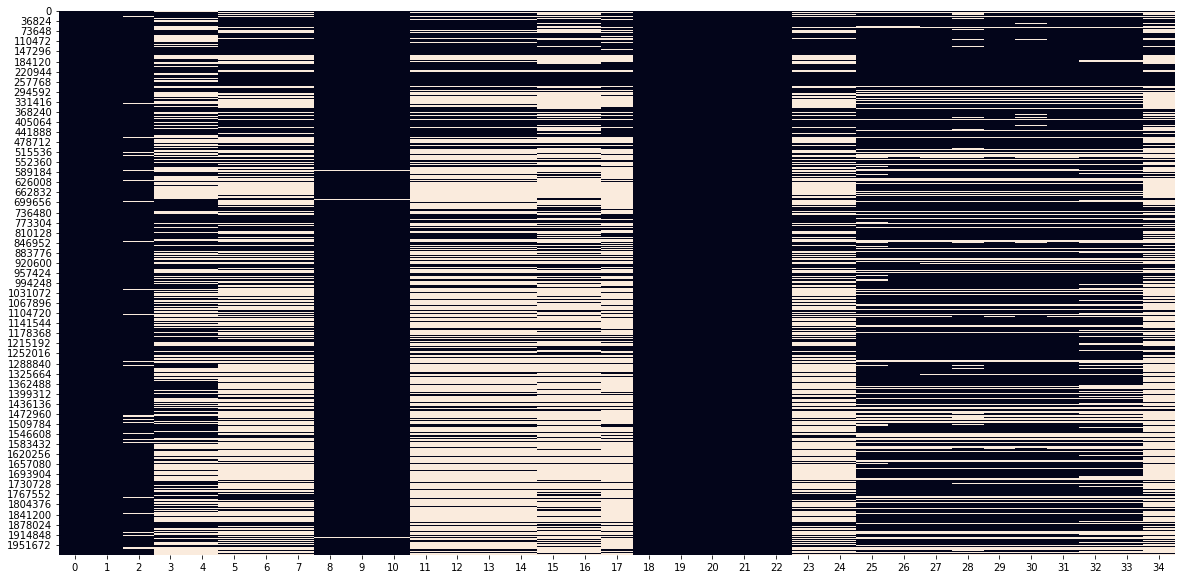

In [40]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

# TODO

continuer à nettoyer le dataset

### 1. formater les categories en lowercase, splitter les tags (one hot ?)

tip : `.apply(fct)` existe en python, ex: `data['taille'] = data['taille'].apply(convert_height)`

### 2. analyser les outliers

### 3. approffondir la distribution des quali et quanti [cours](https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4742171-representez-la-distribution-empirique-dune-variable) 

### 4. discretiser les variables continues

> Le fait d'agréger une variable s'appelle la discrétisation (en anglais : binning, bucketing ou discretization).

empirical cumulative distribution function ([ecdf](https://machinelearningmastery.com/empirical-distribution-function-in-python/)) Dans le cas d'une variable qui ne suit pas une loi normale => est-ce le cas dans ce dataset ?

$ F_{emp}(x)=\frac{1}{n}\sum_{i=1}^{n}I_{\{{x_{i}} \leq x\}}$ 

où I est la fonction indicatrice. 1 si xi <= x, 0 sinon
    
code samples from course: 

```python
import matplotlib.pyplot as plt

# VARIABLE QUALITATIVE
# Diagramme en secteurs
data["categ"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

# Diagramme en tuyaux d'orgues
data["categ"].value_counts(normalize=True).plot(kind='bar')
plt.show()

# VARIABLE QUANTITATIVE
# Diagramme en bâtons
data["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

# Histogramme
data["montant"].hist(density=True)
plt.show()
# Histogramme plus beau
data[data.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()
```

### 5. faire le nombre et la fréquence des valeurs quali (pour toutes celles retenues dans le dataset)

```python
effectifs = data["quart_mois"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

tab = pd.DataFrame(modalites, columns = ["quart_mois"]) # création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["f"] = tab["n"] / len(data) # len(data) renvoie la taille de l'échantillon
```

> modalité
>
> effectif
>
> fréquence
>
> variable qualitative ordinale

### 6. reverifier si la suppression des colonnes à du sens, si ce n'est pas preferable pour certaines de remplir avec une valeur arbitraire (moyenne, autre ...)

### 7. remplacer valeur NaN (`fillna`)

### 8. resample dataset ?
pour diminuer la taille et faciliter les calculs ?  `sklearn.utils.resample`

### 9. Analyse ANOVA

correlation entre variables



## Analysis

In [41]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_1'] )

col_0,Alcoholic beverages,Beverages,Cereals and potatoes,Composite foods,Fat and sauces,Fish Meat Eggs,Fruits and vegetables,Milk and dairy products,Salty snacks,Sugary snacks,unknown
row_0,,,,,,,,,,,
a,1,4475,31525,6949,2696,12563,31084,9059,1750,1217,13583
b,1,8782,14230,13806,4166,12325,5239,14664,2427,2595,15443
c,10,9715,15036,16990,21141,17373,7258,16229,8727,12866,29427
d,21,7387,11859,12251,18650,29252,1048,39250,12277,49815,41992
e,11,15101,2216,1576,9714,16572,115,5027,5308,57922,18502


In [42]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_2'] )

col_0,Alcoholic beverages,Appetizers,Artificially sweetened beverages,Biscuits and cakes,Bread,Breakfast cereals,Cereals,Cheese,Chocolate products,Dairy desserts,...,Salty and fatty products,Sandwiches,Soups,Sweetened beverages,Sweets,Teas and herbal teas and coffees,Unsweetened beverages,Vegetables,Waters and flavored waters,unknown
row_0,,,,,,,,,,,,,,,,,,,,,
a,1,205,71,553,4435,2288,18752,608,9,1141,...,205,308,397,70,642,2,0,21021,3299,13583
b,1,573,1525,939,5682,1270,5312,917,21,1031,...,615,714,1311,980,1583,214,1533,2096,718,15443
c,10,3076,1109,5338,6221,2818,4564,3993,142,3027,...,2756,1120,823,897,7103,202,1474,1883,119,29427
d,21,5582,1213,22182,3802,2287,5016,32393,2065,825,...,5502,1649,40,2251,23118,468,1261,292,50,41992
e,11,1399,1057,28014,295,165,1486,3732,11158,103,...,3676,131,12,8848,16256,252,3279,33,36,18502


ValueError: Could not interpret value `ecoscore_score_fr` for parameter `y`

<Figure size 1440x1440 with 0 Axes>

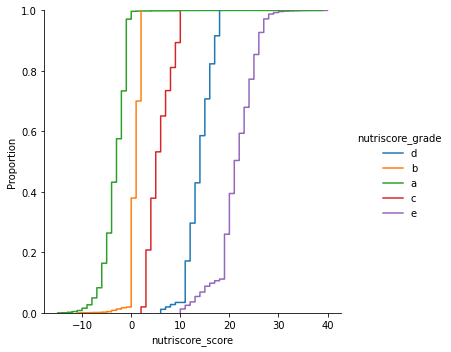

In [43]:
plt.figure(figsize=(20,20))
# sns.displot(df, x='nutriscore_grade')
sns.displot(df, x='nutriscore_score', hue='nutriscore_grade', kind='ecdf')
plt.savefig("nutriscore_grade_multivariate_analysis.png", format='png', dpi=150)
sns.displot(df, x='nutriscore_score', y='ecoscore_score_fr', hue='nutriscore_grade')
# sns.displot(df, x='nutriscore_score', y= 'nova_group', hue='nutriscore_grade', kind='kde')
# sns.displot(df, x='nutriscore_score', col='nutriscore_grade')
plt.savefig("nutriscore_ecoscore_multivariate_analysis.png", format='png', dpi=150)

In [ ]:
df['nutriscore_grade'].value_counts(normalize=True).plot.pie()

In [ ]:
df['nutriscore_score'].dropna().value_counts().sort_values(ascending=False)


We can see that some columns still have lots of empty values, but also that several rows have almost (or all) the features provided,
which is good for further analysis



In [ ]:
# most filled features
df.columns[[0, 1, 11, 12, 13, 25, 26, 27, 28, 29]]

In [ ]:
df.columns.get_loc('nutriscore_grade')